Comparing the cycle mean Southernmost Unblocked Contour of SSH (SUC-SSH) between three resolutions of OM4.

Will compare the satellite observational era mean (1993-2017 overlaps with obs)

In [1]:
import xarray as xr
import dask.array
import numpy as np
import pandas as pd
import os
import scipy.io
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import sys
sys.path.append('/home/Ruth.Moorman/OM4p25_JRA55-do_simulations')
### import required python functions
from om4_tools import *
from ssh_contours import *
## plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as pcm
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import matplotlib.colors as col
import cmocean.cm as cm
from matplotlib import rc, rcParams
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
import sys
sys.path.append('/home/Ruth.Moorman/')
import nclcmaps
import cv2

In [2]:
rcParams["contour.negative_linestyle"] = 'solid'
rc('xtick', labelsize=30) 
rc('ytick', labelsize=30) 
rc('axes', labelsize=30)

*Important note:* I have been using the 1D dimensions yh, xh when I should be using the 2D dimensions geolon and leolat. I will need to recompute a lot of stuff and make sure geolon and geolat are saved as coordinates on products I make so I don't forget their use. Below I demonstrate how much of a difference it makes...

In [3]:
expdir = '/archive/Ruth.Moorman/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/'
static_25 = xr.open_dataset(expdir+'/cycle1/ocean_static/20170101.ocean_static.nc')
bathy_25 = static_25.deptho.load()
land_mask_25 = static_25.wet.load()
geolon_25 = static_25.geolon.load()
geolat_25 = static_25.geolat.load()

In [4]:
exp_dir = '/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p125_IAF_csf_JRA55do1-3_r5_cycle2/gfdl.ncrc4-intel16f2-prod/pp'
static_125 = xr.open_dataset(exp_dir+'/ocean_daily/ocean_daily.static.nc')
bathy_125 = static_125.deptho.load()
land_mask_125 = static_125.wet.load()
geolon_125 = static_125.geolon.load()
geolat_125 = static_125.geolat.load()

In [5]:
static_5 = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ocean_monthly.static.nc')
bathy_5 = static_5.deptho.load()
land_mask_5 = static_5.wet.load()
geolon_5 = static_5.geolon.load()
geolat_5 = static_5.geolat.load()

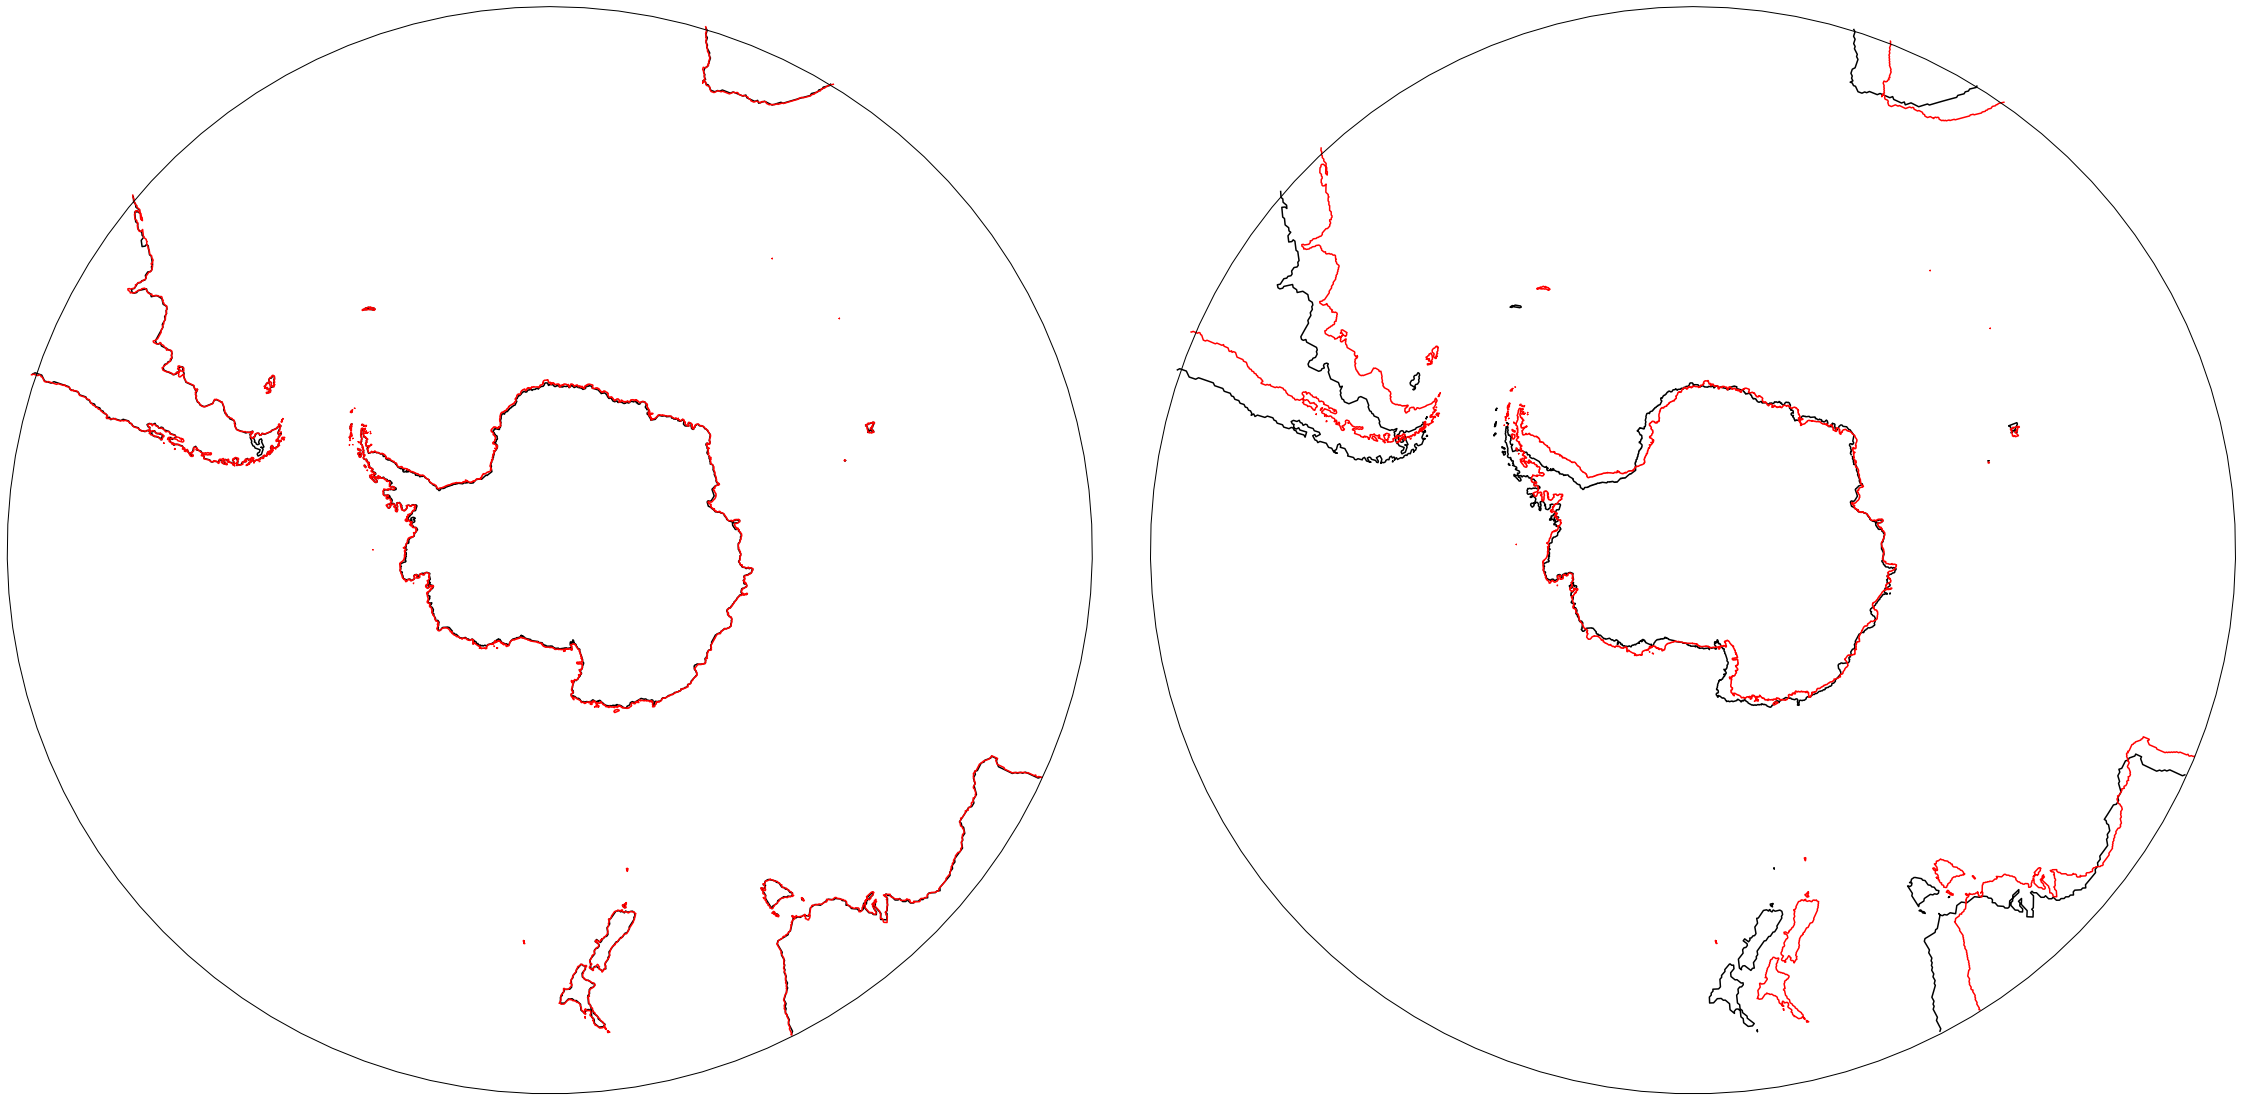

In [8]:
fig = plt.figure(figsize=[40, 20])
gs = gridspec.GridSpec(1,2)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax, ax1 = plt.subplot(gs[0],projection = proj),  plt.subplot(gs[1],projection = proj)
latslice = slice(-90,-29)
gs.update(wspace = 0.05)

ax.contour(geolon_25.sel(yh = latslice), geolat_25.sel(yh = latslice),land_mask_25.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
ax.contour(geolon_125.sel(yh = latslice), geolat_125.sel(yh = latslice),land_mask_125.sel(yh = latslice),[0,1], colors = 'r', alpha = 1, transform=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -29], ccrs.PlateCarree())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)


ax1.contour(land_mask_25.sel(yh = latslice).xh, land_mask_25.sel(yh = latslice).yh,land_mask_25.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
ax1.contour(land_mask_125.sel(yh = latslice).xh, land_mask_125.sel(yh = latslice).yh,land_mask_125.sel(yh = latslice),[0,1], colors = 'r', alpha = 1, transform=ccrs.PlateCarree())
ax1.set_extent([-180, 180, -90, -29], ccrs.PlateCarree())
ax1.set_boundary(circle, transform=ax1.transAxes)

plt.show()

In [6]:
def so_basics(ax,land_mask,geolon, geolat, lat_north = -29, grid = True):
    latslice = slice(-90,lat_north)
    ax.contour(geolon.sel(yh = latslice), geolat.sel(yh = latslice),land_mask.sel(yh = latslice),[0,1], colors = 'k', alpha = 1, transform=ccrs.PlateCarree())
    ax.set_extent([-180, 180, -90, lat_north], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--', alpha = 0.7)
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50, -40, -30])

Southernmost unblocked contour (SUC) of ssh computed and saved using function `OM4_southernmost_continuous_ssh_contour()` (works for all model resolutions). I've reloaded these and svaed them with the geolon/geolat coordinates for ease. 

Called and post processed according to:

`nc = xr.open_mfdataset('/archive/oar.gfdl.ogrp-account/CMIP6/OMIP/xanadu_mom6_20181101/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r_cycle1/gfdl.ncrc4-intel16f2-prod/pp/ocean_monthly/ts/monthly/20yr/ocean_monthly.*.zos.nc')
p5_ssh_cycle1 = nc.zos
p5_ssh_cycle1_mean = p5_ssh_cycle1.sel(time = slice('1993', '2017')).sel(yh = slice(-90, -29)).mean(dim = 'time').load()`

`range_min = np.round(p5_ssh_cycle1_mean.isel(xh = 0).min(dim = 'yh').values, decimals = 3)
test_range = np.arange(range_min+0.002, -1.0, 0.001)
contour_numbered, contour_mask, contour_depth = OM4_southernmost_continuous_ssh_contour(p5_ssh_cycle1_mean, test_range, lat_north = -29)
contour_numbered.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh used'
contour_mask.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh used'
contour_numbered.attrs['contour_ssh_value'] = str(contour_depth)[:6]+' m'
contour_mask.attrs['contour_ssh_value'] = str(contour_depth)[:6]+' m'
p5_ssh_cycle1_mean.attrs['time_avg_info']  = '1993-2017 satellite era mean ssh'
ds = xr.Dataset({'ssh':p5_ssh_cycle1_mean,'contour_mask_numbered':contour_numbered, 'contour_masked_south':contour_mask})
ds.coords['geolon'] = geolon_5
ds.coords['geolat'] = geolat_5
ds.to_netcdf('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh.nc')`

In [10]:
p125_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle1_1993-2017_mean_SUC-ssh.nc')
p125_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle2_1993-2017_mean_SUC-ssh.nc')
p125_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_IAF_csf_JRA55do1-3_r5/cycle3_1993-2017_mean_SUC-ssh.nc')

p125_mle_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle1_1993-2017_mean_SUC-ssh.nc')
p125_mle_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle2_1993-2017_mean_SUC-ssh.nc')
p125_mle_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p125_JRA55do1.4_mle3d/cycle3_1993-2017_mean_SUC-ssh.nc')

p25_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh.nc')
p25_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh.nc')
p25_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p25_IAF_BLING_CFC_csf_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh.nc')

p5_SUCssh_cycle1 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle1_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle2 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle2_1993-2017_mean_SUC-ssh.nc')
p5_SUCssh_cycle3 = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/OM4p5_IAF_BLING_CFC_abio_csf_mle200_JRA55do1-3_r4r/cycle3_1993-2017_mean_SUC-ssh.nc')

In [11]:
cmems_SUCshh = xr.open_dataset('/work/Ruth.Moorman/masks_and_contours/CMEMS-satellite-obs/CMEMS_1993-2017_mean_SUC-ssh.nc')

In [12]:
p5_SUCssh_cycle1_numbered = p5_SUCssh_cycle1.contour_mask_numbered
p5_SUCssh_cycle1_mask = p5_SUCssh_cycle1.contour_masked_south
p5_SUCssh_cycle1_ssh = p5_SUCssh_cycle1.ssh
p5_SUCssh_cycle2_numbered = p5_SUCssh_cycle2.contour_mask_numbered
p5_SUCssh_cycle2_mask = p5_SUCssh_cycle2.contour_masked_south
p5_SUCssh_cycle2_ssh = p5_SUCssh_cycle2.ssh
p5_SUCssh_cycle3_numbered = p5_SUCssh_cycle3.contour_mask_numbered
p5_SUCssh_cycle3_mask = p5_SUCssh_cycle3.contour_masked_south
p5_SUCssh_cycle3_ssh = p5_SUCssh_cycle3.ssh

In [13]:
p25_SUCssh_cycle1_numbered = p25_SUCssh_cycle1.contour_mask_numbered
p25_SUCssh_cycle1_mask = p25_SUCssh_cycle1.contour_masked_south
p25_SUCssh_cycle1_ssh = p25_SUCssh_cycle1.ssh
p25_SUCssh_cycle2_numbered = p25_SUCssh_cycle2.contour_mask_numbered
p25_SUCssh_cycle2_mask = p25_SUCssh_cycle2.contour_masked_south
p25_SUCssh_cycle2_ssh = p25_SUCssh_cycle2.ssh
p25_SUCssh_cycle3_numbered = p25_SUCssh_cycle3.contour_mask_numbered
p25_SUCssh_cycle3_mask = p25_SUCssh_cycle3.contour_masked_south
p25_SUCssh_cycle3_ssh = p25_SUCssh_cycle3.ssh

In [14]:
p125_SUCssh_cycle1_numbered = p125_SUCssh_cycle1.contour_mask_numbered
p125_SUCssh_cycle1_mask = p125_SUCssh_cycle1.contour_masked_south
p125_SUCssh_cycle1_ssh = p125_SUCssh_cycle1.ssh
p125_SUCssh_cycle2_numbered = p125_SUCssh_cycle2.contour_mask_numbered
p125_SUCssh_cycle2_mask = p125_SUCssh_cycle2.contour_masked_south
p125_SUCssh_cycle2_ssh = p125_SUCssh_cycle2.ssh
p125_SUCssh_cycle3_numbered = p125_SUCssh_cycle3.contour_mask_numbered
p125_SUCssh_cycle3_mask = p125_SUCssh_cycle3.contour_masked_south
p125_SUCssh_cycle3_ssh = p125_SUCssh_cycle3.ssh

In [15]:
p125_mle_SUCssh_cycle1_numbered = p125_mle_SUCssh_cycle1.contour_mask_numbered
p125_mle_SUCssh_cycle1_mask = p125_mle_SUCssh_cycle1.contour_masked_south
p125_mle_SUCssh_cycle1_ssh = p125_mle_SUCssh_cycle1.ssh
p125_mle_SUCssh_cycle2_numbered = p125_mle_SUCssh_cycle2.contour_mask_numbered
p125_mle_SUCssh_cycle2_mask = p125_mle_SUCssh_cycle2.contour_masked_south
p125_mle_SUCssh_cycle2_ssh = p125_mle_SUCssh_cycle2.ssh
p125_mle_SUCssh_cycle3_numbered = p125_mle_SUCssh_cycle3.contour_mask_numbered
p125_mle_SUCssh_cycle3_mask = p125_mle_SUCssh_cycle3.contour_masked_south
p125_mle_SUCssh_cycle3_ssh = p125_mle_SUCssh_cycle3.ssh

In [16]:
cmems_SUCshh_numbered = cmems_SUCshh.contour_mask_numbered
cmems_SUCshh_mask = cmems_SUCshh.contour_masked_south
cmems_SUCshh_ssh = cmems_SUCshh.ssh

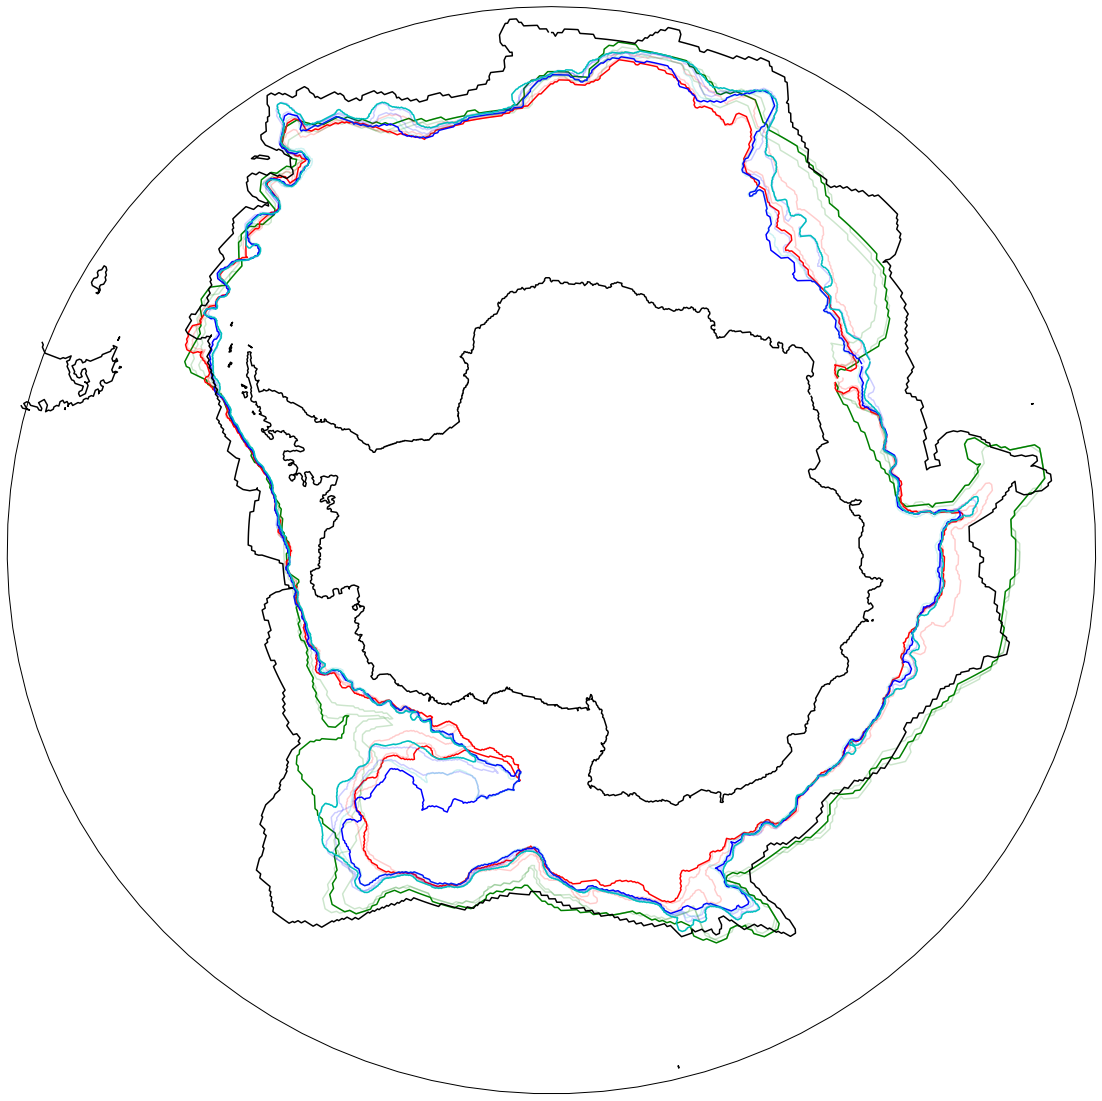

In [17]:
fig = plt.figure(figsize=[20, 20])
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax = plt.subplot(projection = proj)
lat_north = -50
so_basics(ax,land_mask_25,geolon_25, geolat_25, lat_north = lat_north, grid = False)

ax.contour(p5_SUCssh_cycle1_mask.geolon, p5_SUCssh_cycle1_mask.geolat,p5_SUCssh_cycle1_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p5_SUCssh_cycle2_mask.geolon, p5_SUCssh_cycle2_mask.geolat,p5_SUCssh_cycle2_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p5_SUCssh_cycle3_mask.geolon, p5_SUCssh_cycle3_mask.geolat,p5_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'g',alpha = 1,transform = ccrs.PlateCarree())

ax.contour(p25_SUCssh_cycle1_mask.geolon, p25_SUCssh_cycle1_mask.geolat,p25_SUCssh_cycle1_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p25_SUCssh_cycle2_mask.geolon, p25_SUCssh_cycle2_mask.geolat,p25_SUCssh_cycle2_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p25_SUCssh_cycle3_mask.geolon, p25_SUCssh_cycle3_mask.geolat,p25_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'r',alpha = 1,transform = ccrs.PlateCarree())

ax.contour(p125_SUCssh_cycle1_mask.geolon, p125_SUCssh_cycle1_mask.geolat,p125_SUCssh_cycle1_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p125_SUCssh_cycle2_mask.geolon, p125_SUCssh_cycle2_mask.geolat,p125_SUCssh_cycle2_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p125_SUCssh_cycle3_mask.geolon, p125_SUCssh_cycle3_mask.geolat,p125_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())

ax.contour(p125_mle_SUCssh_cycle1_mask.geolon, p125_mle_SUCssh_cycle1_mask.geolat,p125_mle_SUCssh_cycle1_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p125_mle_SUCssh_cycle2_mask.geolon, p125_mle_SUCssh_cycle2_mask.geolat,p125_mle_SUCssh_cycle2_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 0.2,transform = ccrs.PlateCarree())
ax.contour(p125_mle_SUCssh_cycle3_mask.geolon, p125_mle_SUCssh_cycle3_mask.geolat,p125_mle_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'c',alpha = 1,transform = ccrs.PlateCarree())


ax.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'k',alpha = 1,transform = ccrs.PlateCarree())
plt.show()

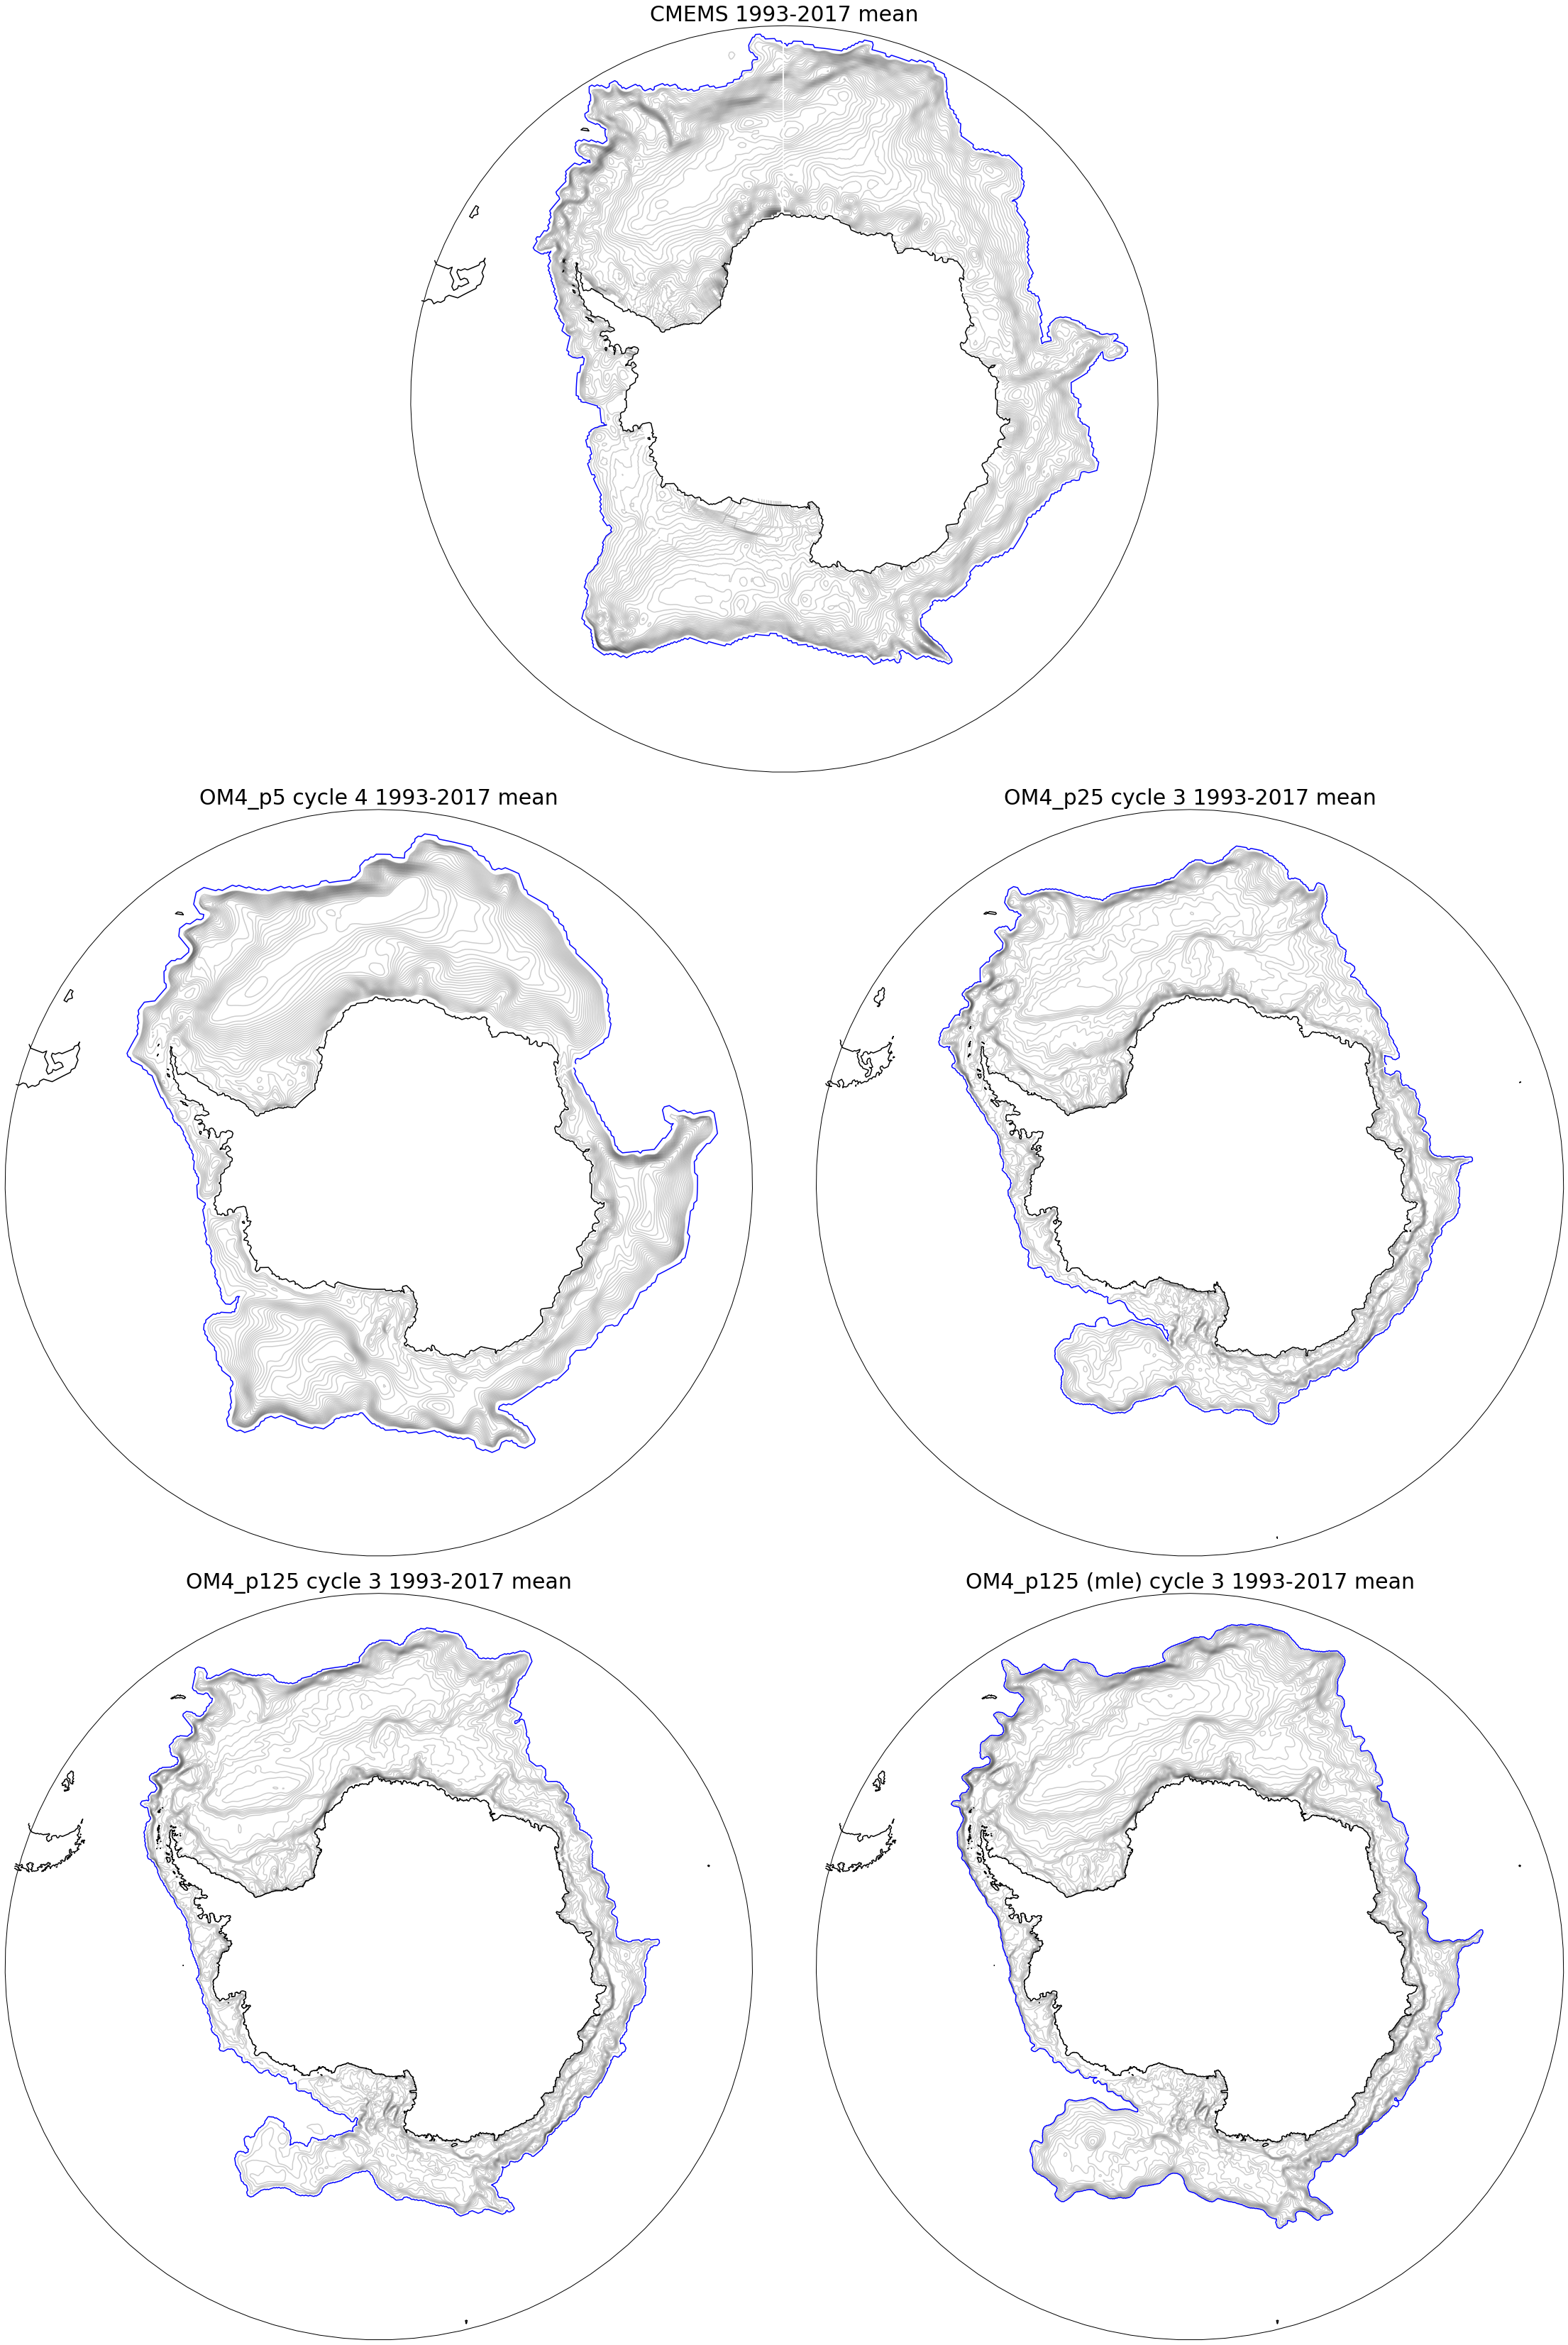

In [19]:
fig = plt.figure(figsize=[40, 60])
gs = gridspec.GridSpec(3,2)
proj = ccrs.Stereographic(central_longitude=0,central_latitude=-90)
ax, ax1, ax2,ax3 = plt.subplot(gs[1,0],projection = proj),  plt.subplot(gs[1,1],projection = proj),  plt.subplot(gs[2,0],projection = proj),  plt.subplot(gs[2,1],projection = proj)
ax4 = plt.subplot(gs[0,:],projection = proj)
gs.update(wspace = 0.05, hspace = 0.05)

so_basics(ax4,land_mask_5,geolon_5, geolat_5, lat_north = -50, grid = False)
ax4.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
levels = np.arange(-1.6,-1.05, 0.01)
ax4.contour(cmems_SUCshh_mask.longitude, cmems_SUCshh_mask.latitude,cmems_SUCshh_ssh, levels = levels, colors = 'k',linewidth = 0.2,alpha = 0.2,transform = ccrs.PlateCarree())
ax4.set_title('CMEMS 1993-2017 mean', fontsize = 30)

so_basics(ax,land_mask_5,geolon_5, geolat_5, lat_north = -50, grid = False)
ax.contour(p5_SUCssh_cycle3_mask.geolon, p5_SUCssh_cycle3_mask.geolat,p5_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
levels = np.arange(-1.921,-1.60, 0.01)
ax.contour(p5_SUCssh_cycle3_ssh.geolon, p5_SUCssh_cycle3_ssh.geolat,p5_SUCssh_cycle3_ssh, levels = levels, colors = 'k',linewidth = 0.2,alpha = 0.2,transform = ccrs.PlateCarree())
ax.set_title('OM4_p5 cycle 4 1993-2017 mean', fontsize = 30)

so_basics(ax1,land_mask_25,geolon_25, geolat_25, lat_north = -50, grid = False)
ax1.contour(p25_SUCssh_cycle3_mask.geolon, p25_SUCssh_cycle3_mask.geolat,p25_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
levels = np.arange(-1.884,-1.647, 0.01)
ax1.contour(p25_SUCssh_cycle3_ssh.geolon, p25_SUCssh_cycle3_ssh.geolat,p25_SUCssh_cycle3_ssh, levels = levels, colors = 'k',linewidth = 0.2,alpha = 0.2,transform = ccrs.PlateCarree())
ax1.set_title('OM4_p25 cycle 3 1993-2017 mean', fontsize = 30)

so_basics(ax2,land_mask_125,geolon_125, geolat_125, lat_north = -50, grid = False)
ax2.contour(p125_SUCssh_cycle3_mask.geolon, p125_SUCssh_cycle3_mask.geolat,p125_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
levels = np.arange(-1.792,-1.546, 0.01)
ax2.contour(p125_SUCssh_cycle3_ssh.geolon, p125_SUCssh_cycle3_ssh.geolat,p125_SUCssh_cycle3_ssh, levels = levels, colors = 'k',linewidth = 0.2,alpha = 0.2,transform = ccrs.PlateCarree())
ax2.set_title('OM4_p125 cycle 3 1993-2017 mean', fontsize = 30)

so_basics(ax3,land_mask_125,geolon_125, geolat_125, lat_north = -50, grid = False)
ax3.contour(p125_mle_SUCssh_cycle3_mask.geolon, p125_mle_SUCssh_cycle3_mask.geolat,p125_mle_SUCssh_cycle3_mask.fillna(0), levels = [0,1], colors = 'b',alpha = 1,transform = ccrs.PlateCarree())
levels = np.arange(-1.894,-1.571, 0.01)
ax3.contour(p125_mle_SUCssh_cycle3_ssh.geolon, p125_mle_SUCssh_cycle3_ssh.geolat,p125_mle_SUCssh_cycle3_ssh, levels = levels, colors = 'k',linewidth = 0.2,alpha = 0.2,transform = ccrs.PlateCarree())
ax3.set_title('OM4_p125 (mle) cycle 3 1993-2017 mean', fontsize = 30)

figurepath = 'SUC-ssh-OM4.png'
plt.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches='tight', pad_inches=0.15,frameon=None)

plt.show()